In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [2]:
files = glob('data/faces94/**/*.jpg', recursive=True)
print("Image paths:", files)

Image paths: ['data/faces94/malestaff/tony/tony.17.jpg', 'data/faces94/malestaff/tony/tony.7.jpg', 'data/faces94/malestaff/tony/tony.6.jpg', 'data/faces94/malestaff/tony/tony.16.jpg', 'data/faces94/malestaff/tony/tony.14.jpg', 'data/faces94/malestaff/tony/tony.4.jpg', 'data/faces94/malestaff/tony/tony.5.jpg', 'data/faces94/malestaff/tony/tony.15.jpg', 'data/faces94/malestaff/tony/tony.11.jpg', 'data/faces94/malestaff/tony/tony.1.jpg', 'data/faces94/malestaff/tony/tony.10.jpg', 'data/faces94/malestaff/tony/tony.12.jpg', 'data/faces94/malestaff/tony/tony.2.jpg', 'data/faces94/malestaff/tony/tony.3.jpg', 'data/faces94/malestaff/tony/tony.13.jpg', 'data/faces94/malestaff/tony/tony.20.jpg', 'data/faces94/malestaff/tony/tony.18.jpg', 'data/faces94/malestaff/tony/tony.8.jpg', 'data/faces94/malestaff/tony/tony.9.jpg', 'data/faces94/malestaff/tony/tony.19.jpg', 'data/faces94/malestaff/anonym/anonym.20.jpg', 'data/faces94/malestaff/anonym/anonym.8.jpg', 'data/faces94/malestaff/anonym/anonym.19.j

In [24]:
def load_data(files):
    images = []
    for file in files:
        img = cv2.imread(file)
        images.append(img)
    return images

In [25]:
data = load_data(files)
data_arr = np.array(data)

## Average Face

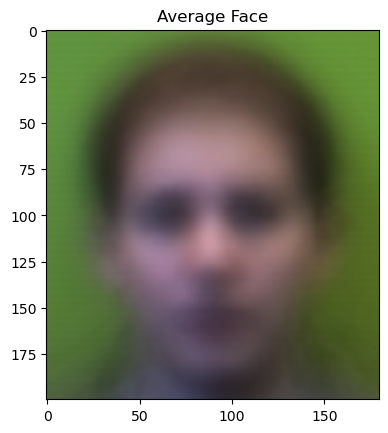

In [26]:
average_face = np.mean(data_arr, axis=0).astype(np.uint8)
plt.imshow(cv2.cvtColor(average_face, cv2.COLOR_BGR2RGB))
plt.title("Average Face")
plt.show()

In [27]:
flatten_data = data_arr.reshape(data_arr.shape[0], -1)
print("Flatten data shape:", flatten_data.shape)

Flatten data shape: (3059, 108000)


In [28]:
def pca(X, n_components):
    mean = np.mean(X, axis=0)
    n = X.shape[0]
    X = X - mean
    feature_corr = X @ X.T
    eigvals, eigvecs = np.linalg.eig(feature_corr)
    top_eigvecs = eigvecs[:, :n_components]
    top_eigenvalues = eigvals[:n_components]
    normalization = 1 / np.sqrt(n * top_eigenvalues)
    print("Top eigenvalues:", top_eigenvalues.shape)
    print("Top eigenvectors:", top_eigvecs.shape)
    print("Normalization shape:", normalization.shape)
    U = X.T @ top_eigvecs @ np.diag(normalization) 
    return U
    

In [29]:
eigenfaces = pca(flatten_data, 5)

Top eigenvalues: (5,)
Top eigenvectors: (3059, 5)
Normalization shape: (5,)


In [30]:
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

eigenfaces = min_max_normalize(eigenfaces)
print("Normalized eigenfaces:", eigenfaces)

Normalized eigenfaces: [[0.54864198 0.45450915 0.46414427 0.51018352 0.51608762]
 [0.64265791 0.40640041 0.43969096 0.50474355 0.56336141]
 [0.58909765 0.43358878 0.45604404 0.48453599 0.53029771]
 ...
 [0.41438257 0.46396297 0.33939218 0.56802613 0.3671932 ]
 [0.47773831 0.3996792  0.31809519 0.60018049 0.25934494]
 [0.45635061 0.39803933 0.32706234 0.59590151 0.32386096]]


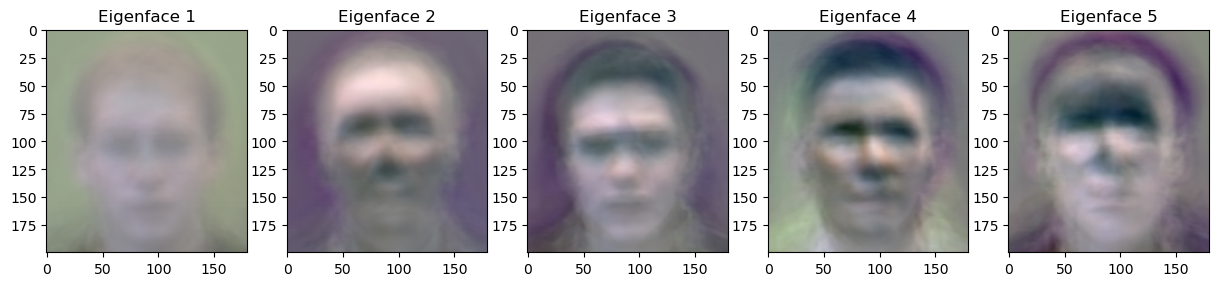

In [34]:
fig, axes = plt.subplots(1, 5, figsize=(15, 8))
for i in range(5):
    ax = axes[i]
    eigenface = eigenfaces[:, i].reshape(average_face.shape)
    ax.imshow(cv2.cvtColor((eigenface * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    ax.set_title(f"Eigenface {i+1}")
plt.show()